In [1]:
# In this notebook we perform a clustering analysis from variational GMMs with a 2D artificial dataset (N=5000 D=2)

In [2]:
import time
import subprocess
import numpy as np
from pathlib import Path
from utils import read_parameters, plot_center_evolution
import matplotlib.pyplot as plt

from time import gmtime, strftime
start_time = time.time()

## Parameters

In [3]:
# data parameters
name                    = 'artificial'
training_path           = '../data-generation/'+name+'/artificial.npy' # path to training features
test_path               = '' # path to test features (empty string if we don't want a test set)
sample_percentage       = 100 # take a data sample for the training set instead of full data (between 1 and 100)

# model parameters
algorithm               = 3 # 0:k-means | 1:S-GMM | 2:S-GMM-Prior | 3:D-GMM | 4:D-GMM-Prior
M                       = 20 # number of cluster centers
H                       = 3 # number of clusters considered for each data point
R                       = 6 # number of new samples
Nprime                  = 0 # size of subset | set to 0 to disable coreset creation
stream                  = False # stream data from harddrive to build coreset | training data not loaded and only works when using coresets
chain_length            = 10 # chain length for AFK-MC² seeding
convergence_threshold   = 0.0001 # < 1 for convergence threshold | >= 1 for epochs

# output parameters
trials                  = 100 # number of runs in parallel
top_k                   = 1 # save the k best clusters during inference
inference               = False # save cluster assignments for training and test datasets (when streaming doesn't work for training set)
save_additional_info    = 1 # 1: save centers, error, and priors across iterations | 2: only priors
verbose                 = 1 # display output in C++ (1 or 2 for even more information)
save_figures            = False # save figures after plotting

## Run C++ GMM standalone executable

In [4]:
start_time = time.time()

save_path = Path('results/'+name+str(M))
 
if algorithm == 0:
    # k-means baselines
    cmd_list = ['../build/release/km', 
                training_path, 
                test_path, 
                str(save_path), 
                str(sample_percentage),
                str(M), 
                str(Nprime),
                str(int(stream)), 
                str(convergence_threshold), 
                str(trials), 
                str(int(inference)),
                str(int(save_additional_info)), 
                str(int(verbose)), 
               ]
else:
    # gmm algorithms
    cmd_list = ['../build/release/gmm',
                training_path, 
                test_path, 
                str(save_path),
                str(sample_percentage),
                str(algorithm),
                str(M),   
                str(H),                                   
                str(R),                                    
                str(Nprime),
                str(int(stream)),                        
                str(chain_length),                                     
                str(convergence_threshold), 
                str(trials),
                str(top_k),
                str(int(inference)),
                str(0),
                str(int(save_additional_info)), 
                str(int(verbose)),
               ]

# running C++ executable within Python
p = subprocess.run(cmd_list, capture_output=True, universal_newlines=True)
if len(p.stderr) > 0: print(p.stderr)
    
print('--- %s seconds ---' % (time.time() - start_time))

--- 7.871084928512573 seconds ---


## Reading model parameters

In [5]:
model_parameters = read_parameters(save_path/'0')

## Centers across iterations

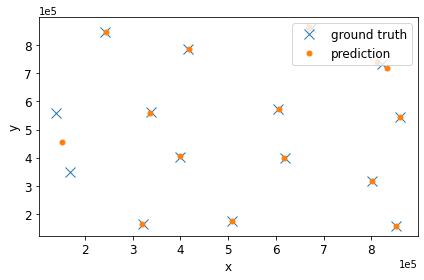

In [6]:
from matplotlib import rc
import matplotlib.animation as animation
from IPython.display import HTML

# creating animation
anim = plot_center_evolution(save_path/'0', ground_truth='../data-generation/'+name+'/artificial_centroids.npy', save_figure=save_figures)
anim

## Quantization error across iterations

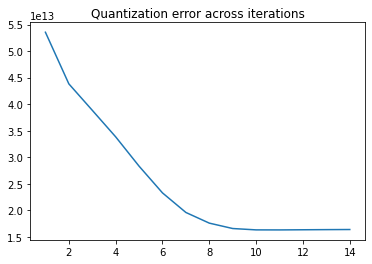

In [7]:
error = [np.load(save_path/'0'/'tr_quantization'/str(str(i)+'.npy'))[0] for i in model_parameters.iteration]

fig2 = plt.figure()
plt.plot(model_parameters.iteration[1:], error[1:])
plt.title('Quantization error across iterations')
plt.show()

if save_figures:
    fig2.savefig(save_path/'quantization_iters.pdf', dpi=300, bbox_inches='tight')

## Free energy across iterations

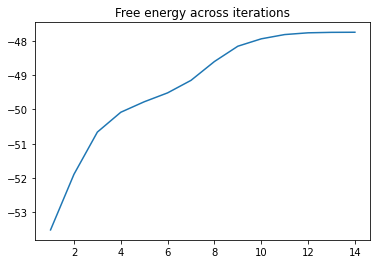

In [8]:
fig3 = plt.figure()
plt.plot(model_parameters.iteration[1:], model_parameters.free_energy[1:])
plt.title('Free energy across iterations')
plt.show()

if save_figures:
    fig3.savefig(save_path/'free_energy_iters.pdf', dpi=300, bbox_inches='tight')

## Sigma across iterations

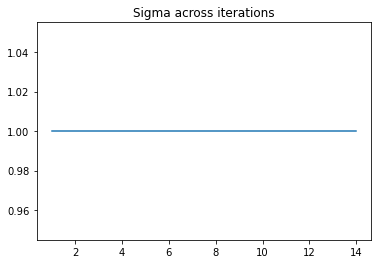

In [9]:
fig4 = plt.figure()
plt.plot(model_parameters.iteration[1:], model_parameters.sigma[1:])
plt.title('Sigma across iterations')
plt.show()

if save_figures:
    fig4.savefig(save_path/'sigma_iters.pdf', dpi=300, bbox_inches='tight')

## Average prior decay

In [10]:
if algorithm == 2 and save_additional_info > 0: # only works with a fixed number of iterations
    priors = np.zeros((trials, M))
    for i in np.arange(trials):
        model_parameters = read_parameters(save_path/str(i))
        prior_path = save_path/str(i)/'priors'
        priors[i] = np.sort(np.array([np.load(prior_path/str(str(j)+'.npy')) for j in model_parameters.iteration]).T[:,-1])[::-1]
     
    initial_prior = np.load(save_path/'0'/'priors'/'0.npy')
    mean_priors = np.mean(priors, axis=0)
    std_priors = np.std(priors, axis=0)
    
    fig, ax = plt.subplots()
    plt.hlines(y=initial_prior, linestyle=':', xmin=0, xmax=M-1, label='Prior distribution before training')
    plt.errorbar(np.arange(len(mean_priors)),mean_priors, std_priors,label='Prior distribution after training')

    plt.xlabel('Cluster number')
    ax.set_xticks(range(0,len(mean_priors),2))
    ax.set_xticklabels(np.arange(1,len(mean_priors)+1,2))
    plt.legend()
    ax.set_ylabel(r'prior ($\alpha$) probability')

    if save_figures:
        fig.savefig(save_path/str('priors_decay%s.pdf' %M))

In [11]:
print('--- %s seconds ---' % (time.time() - start_time))

--- 9.855844020843506 seconds ---
